# Final Experiments - Single-label CNN

## Utilities and Imports

In [8]:
%reload_ext autoreload
%autoreload 2

import itertools
from collections import Counter
import numpy as np
import random
import pickle
from operator import itemgetter
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = [5, 10]

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from fastai import text as ft
from fastai import dataloader as fd
from fastai import dataset as fs
from fastai import learner as fl
from fastai import core as fc
from fastai import metrics as fm


from skai.runner import TextRunner, Adam_lambda
from skai.mwrapper import MWrapper, SKModel
from skai.utils import multi_to_text_out, vote_pred
from skai.utils import get_classification_type, weights_init, multilabel_prediction
from skai.dataset import TokenDataset, SimpleDataset
from skai.metrics import f1_micro_skai


def mapt(f, *iters):
    return tuple(map(f, *iters))

def mapl(f, *iters):
    return list(map(f, *iters))

def manually_remove_problems(data):
    """ remove problem from data if it has a certain tag"""
    final_data = {}
    remove = ['*special']
    for i in data:
        if set(data[i][1][0]).intersection(set(remove)) == set():
            if data[i][0][0] != '':
                final_data[i] = data[i]
    return final_data

def get_single_label_problems(data):
    '''returns a dict of all problems which only have one label'''
    single_label_problems = {}
    for i in data:
        if len(data[i][1][0]) == 1:
            single_label_problems[i] = data[i]
    return single_label_problems

def get_classwise_distribution(data):
    class_count = {}
    for i in data:
        for cls in data[i][1][0]:
            if cls in class_count:
                class_count[cls] +=1 
            else:
                class_count[cls] = 1
    return class_count


def get_topk_single_label_problems(data,k):
    """ get top k by frequency single label problems"""
    class_dict = get_classwise_distribution(data)
    print(class_dict)
    class_dict = dict(sorted(class_dict.items(), key=itemgetter(1), reverse=True)[:k])
    print(set(class_dict.keys()))

    topk_data = {}
    for i in data:
        if set(data[i][1][0]).intersection(set(class_dict.keys())) != set():
            topk_data[i] = data[i]
            
    return topk_data

def make_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][2])
    return Xtext, ytext

def make_non_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(f'{data[0][3]}\n{data[0][4]}\n{data[0][5]}')
    return Xtext, ytext

def get_class_list(labels):
    return list(set(labels))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.gcf()
    fig.set_size_inches(22, 16)
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
#     plt.title(title, fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=32)
    plt.yticks(tick_marks, classes, fontsize=32)

    print(cm.max())
    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=32)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=32)
    plt.xlabel('Predicted label', fontsize=32)

[autoreload of numpy failed: Traceback (most recent call last):
  File "/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/home/aayn/anaconda3/envs/fastai/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/aayn/anaconda3/envs/fastai/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/numpy/__init__.py", line 151, in <module>
    from .testing import Tester, _

[autoreload of pkg_resources.extern.six failed: Traceback (most recent call last):
  File "/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/home/aayn/anaconda3/envs/fastai/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/aayn/anaconda3/envs/fastai/lib/python3.6/importlib/__init__.py", line 147, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module pkg_resources._vendor.six not in sys.modules
]
[autoreload of pkg_resources.extern.appdirs failed: Traceback (most recent call last):
  File "/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)


## Load data

In [10]:
top5s = pickle.load(open('data/110_5single_26aug.pkl','rb'))
top10s = pickle.load(open('data/10single_26aug.pkl','rb'))

top5s, top10s = mapt(make_text_dataset, [top5s, top10s])

In [11]:
print(len(top10s[0]))
print(set(top10s[1]))

1159
{'data structures', 'brute force', 'dp', 'geometry', 'dfs and similar', 'constructive algorithms', 'greedy', 'implementation', 'math', 'strings'}


In [12]:
print(top5s[0][0])

F. One Occurrence
time limit per test3 seconds
memory limit per test768 megabytes
inputstandard input
outputstandard output
You are given an array a
consisting of n
integers, and q
queries to it. i
-th query is denoted by two integers li
and ri
. For each query, you have to find any integer that occurs exactly once in the subarray of a
from index li
to index ri
(a subarray is a contiguous subsegment of an array). For example, if a=[1,1,2,3,2,4]
, then for query (li=2,ri=6)
the subarray we are interested in is [1,2,3,2,4]
, and possible answers are 1
, 3
and 4
; for query (li=1,ri=2)
the subarray we are interested in is [1,1]
, and there is no such element that occurs exactly once.
Can you answer all of the queries?
Input
The first line contains one integer n
(1≤n≤5⋅105
).
The second line contains n
integers a1,a2,…,an
(1≤ai≤5⋅105
).
The third line contains one integer q
(1≤q≤5⋅105
).
Then q
lines follow, i
-th line containing two integers li
and ri
representing i
-th query (1≤li≤ri≤n
)

## CNN Experiments

In [13]:
class CNN_Text(nn.Module):
    def __init__(self, embed_num, class_num, channel_in=1, 
                 kernel_sizes=[3, 4, 5], kernel_num=512, embed_dim=300):
        super().__init__()
        self.kernel_num = kernel_num
        self.embed = nn.Embedding(embed_num, embed_dim)
        
        convs = [nn.Conv1d(1, kernel_num, (ks, embed_dim))
                 for ks in kernel_sizes]
        self.convs = nn.ModuleList(convs)
        self.fc1 = nn.Linear(len(kernel_sizes) * kernel_num, class_num)
    
    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x
    
    def forward(self, x):
        x = self.embed(x)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        
        out = self.fc1(x)
        return out

### 5-class

In [11]:
trunner = TextRunner([None], top5s[0], top5s[1], 'top5s')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

Checkpoint reached: raw data cleaned.
multiclass classification.


In [12]:
itos = trunner.alldata.tvectorizer.itos

In [13]:
runs = 1
out_dim = 5

preds_txt, targs_txt = [], []
X_test_txt = []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textcnn = MWrapper(CNN_Text(in_dim, out_dim),
                           f'{i}_cnntext5s_{j}')
        textcnn.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleDataset(X_train, y_train),
                                 batch_size=32, num_workers=2,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleDataset(X_test, y_test),
                               batch_size=32, num_workers=2,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textcnn.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textcnn.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 10, best_save_name='best')
        
#         print(X_test[0])
        X_txt = mapl(lambda x: ' '.join([itos[k] for k in x]), X_test)
#         print(X_txt[0])
        X_test_txt += X_txt
#         print(multi_to_text_out(X_test[0], trunner.alldata.tvectorizer))
        
        dl_test = fd.DataLoader(SimpleDataset(X_test, y_test),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        preds_txt += multi_to_text_out(preds, trunner.alldata.ovectorizer)
        targs_txt += multi_to_text_out(targs, trunner.alldata.ovectorizer)
        print(accuracy_score(targs_txt, preds_txt))

Note: Model directory for 0_cnntext5s_0 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.167444   0.158873   0.309091  
    1      0.156054   0.15038    0.345455                  
    2      0.143507   0.136806   0.527273                  
    3      0.128329   0.128118   0.509091                  
    4      0.112345   0.12556    0.527273                  
    5      0.096027   0.123787   0.545455                   
    6      0.079692   0.121794   0.581818                   
    7      0.064003   0.122044   0.581818                   
    8      0.049902   0.123336   0.581818                   
    9      0.037959   0.125175   0.563636                   

0.5818181818181818
Note: Model directory for 0_cnntext5s_1 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.166006   0.160231   0.181818  
    1      0.155344   0.150415   0.4                       
    2      0.143512   0.138932   0.454545                  
    3      0.129067   0.130709   0.490909                  
    4      0.113353   0.127171   0.490909                  
    5      0.09694    0.123354   0.581818                   
    6      0.080279   0.12162    0.581818                   
    7      0.06435    0.121279   0.581818                   
    8      0.050037   0.121035   0.6                        
    9      0.038005   0.120557   0.581818                   

0.5909090909090909
Note: Model directory for 0_cnntext5s_2 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.1685     0.158391   0.2       
    1      0.157562   0.148549   0.418182                  
    2      0.145836   0.134917   0.581818                  
    3      0.131182   0.122432   0.618182                  
    4      0.115292   0.116933   0.636364                  
    5      0.099163   0.11498    0.654545                   
    6      0.082889   0.113225   0.636364                   
    7      0.066991   0.113067   0.654545                   
    8      0.052456   0.113426   0.636364                   
    9      0.040014   0.114142   0.636364                   

0.6121212121212121
Note: Model directory for 0_cnntext5s_3 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.164968   0.157866   0.181818  
    1      0.154365   0.145058   0.472727                  
    2      0.142067   0.132758   0.527273                  
    3      0.126909   0.123772   0.545455                  
    4      0.110745   0.120373   0.563636                  
    5      0.094436   0.1174     0.545455                   
    6      0.07827    0.11541    0.563636                   
    7      0.062856   0.115912   0.581818                   
    8      0.048962   0.116946   0.618182                   
    9      0.037176   0.118224   0.618182                   

0.6136363636363636
Note: Model directory for 0_cnntext5s_4 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.166137   0.157831   0.290909  
    1      0.156105   0.149746   0.381818                  
    2      0.145033   0.138274   0.418182                  
    3      0.130689   0.127925   0.418182                  
    4      0.11463    0.122757   0.436364                  
    5      0.09821    0.119324   0.472727                   
    6      0.081739   0.11738    0.509091                   
    7      0.065915   0.117523   0.509091                   
    8      0.051601   0.117834   0.490909                   
    9      0.0394     0.118486   0.472727                   

0.5927272727272728
Note: Model directory for 0_cnntext5s_5 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.166939   0.157807   0.2       
    1      0.156976   0.150142   0.363636                  
    2      0.146217   0.137643   0.472727                  
    3      0.132247   0.124806   0.490909                  
    4      0.116806   0.116693   0.563636                  
    5      0.100899   0.112278   0.581818                  
    6      0.084632   0.109579   0.581818                   
    7      0.068716   0.109173   0.6                        
    8      0.054154   0.109128   0.618182                   
    9      0.041604   0.108546   0.636364                   

0.6
Note: Model directory for 0_cnntext5s_6 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.16643    0.15905    0.290909  
    1      0.155451   0.152757   0.454545                  
    2      0.143421   0.142036   0.472727                  
    3      0.128669   0.133057   0.490909                  
    4      0.112928   0.126015   0.509091                  
    5      0.096791   0.121489   0.527273                   
    6      0.080448   0.121946   0.509091                   
    7      0.064697   0.122114   0.509091                   
    8      0.05039    0.12188    0.545455                   
    9      0.038251   0.122036   0.563636                   

0.5948051948051948
Note: Model directory for 0_cnntext5s_7 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.165277   0.156655   0.381818  
    1      0.155785   0.148338   0.472727                  
    2      0.144485   0.13494    0.545455                  
    3      0.12994    0.123722   0.527273                  
    4      0.11419    0.119741   0.545455                  
    5      0.097908   0.117317   0.618182                  
    6      0.081373   0.1161     0.654545                   
    7      0.065392   0.11682    0.636364                   
    8      0.050925   0.116971   0.618182                   
    9      0.038638   0.116644   0.6                        

0.6022727272727273
Note: Model directory for 0_cnntext5s_8 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.166726   0.160739   0.309091  
    1      0.156119   0.15571    0.236364                  
    2      0.144736   0.144905   0.4                       
    3      0.13068    0.135605   0.436364                  
    4      0.114854   0.130044   0.490909                  
    5      0.098234   0.124433   0.581818                   
    6      0.081511   0.12153    0.581818                   
    7      0.065572   0.122168   0.581818                   
    8      0.051248   0.122303   0.581818                   
    9      0.039082   0.121853   0.563636                   

0.6
Note: Model directory for 0_cnntext5s_9 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.16532    0.154939   0.436364  
    1      0.155069   0.143613   0.490909                  
    2      0.143774   0.131935   0.563636                  
    3      0.129822   0.121784   0.6                       
    4      0.114194   0.115396   0.654545                  
    5      0.097648   0.10688    0.672727                   
    6      0.080641   0.102543   0.690909                   
    7      0.064254   0.100523   0.690909                   
    8      0.049566   0.099505   0.709091                   
    9      0.037322   0.099427   0.709091                   

0.610909090909091


In [25]:
print(len(X_test_txt), len(preds_txt))

550 550


In [16]:
# pickle.dump([preds_txt, targs_txt], open('data/results/cnn_5s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/cnn_5s.pkl', 'rb'))

                 precision    recall  f1-score   support

data structures       0.66      0.90      0.76       110
             dp       0.59      0.53      0.56       110
         greedy       0.65      0.37      0.47       110
 implementation       0.57      0.73      0.64       110
           math       0.60      0.53      0.56       110

    avg / total       0.61      0.61      0.60       550

0.610909090909091
0.597677499384587
Normalized confusion matrix
[[0.9     0.02727 0.00909 0.02727 0.03636]
 [0.17273 0.52727 0.12727 0.08182 0.09091]
 [0.10909 0.12727 0.37273 0.27273 0.11818]
 [0.06364 0.07273 0.02727 0.72727 0.10909]
 [0.11818 0.14545 0.03636 0.17273 0.52727]]
0.9


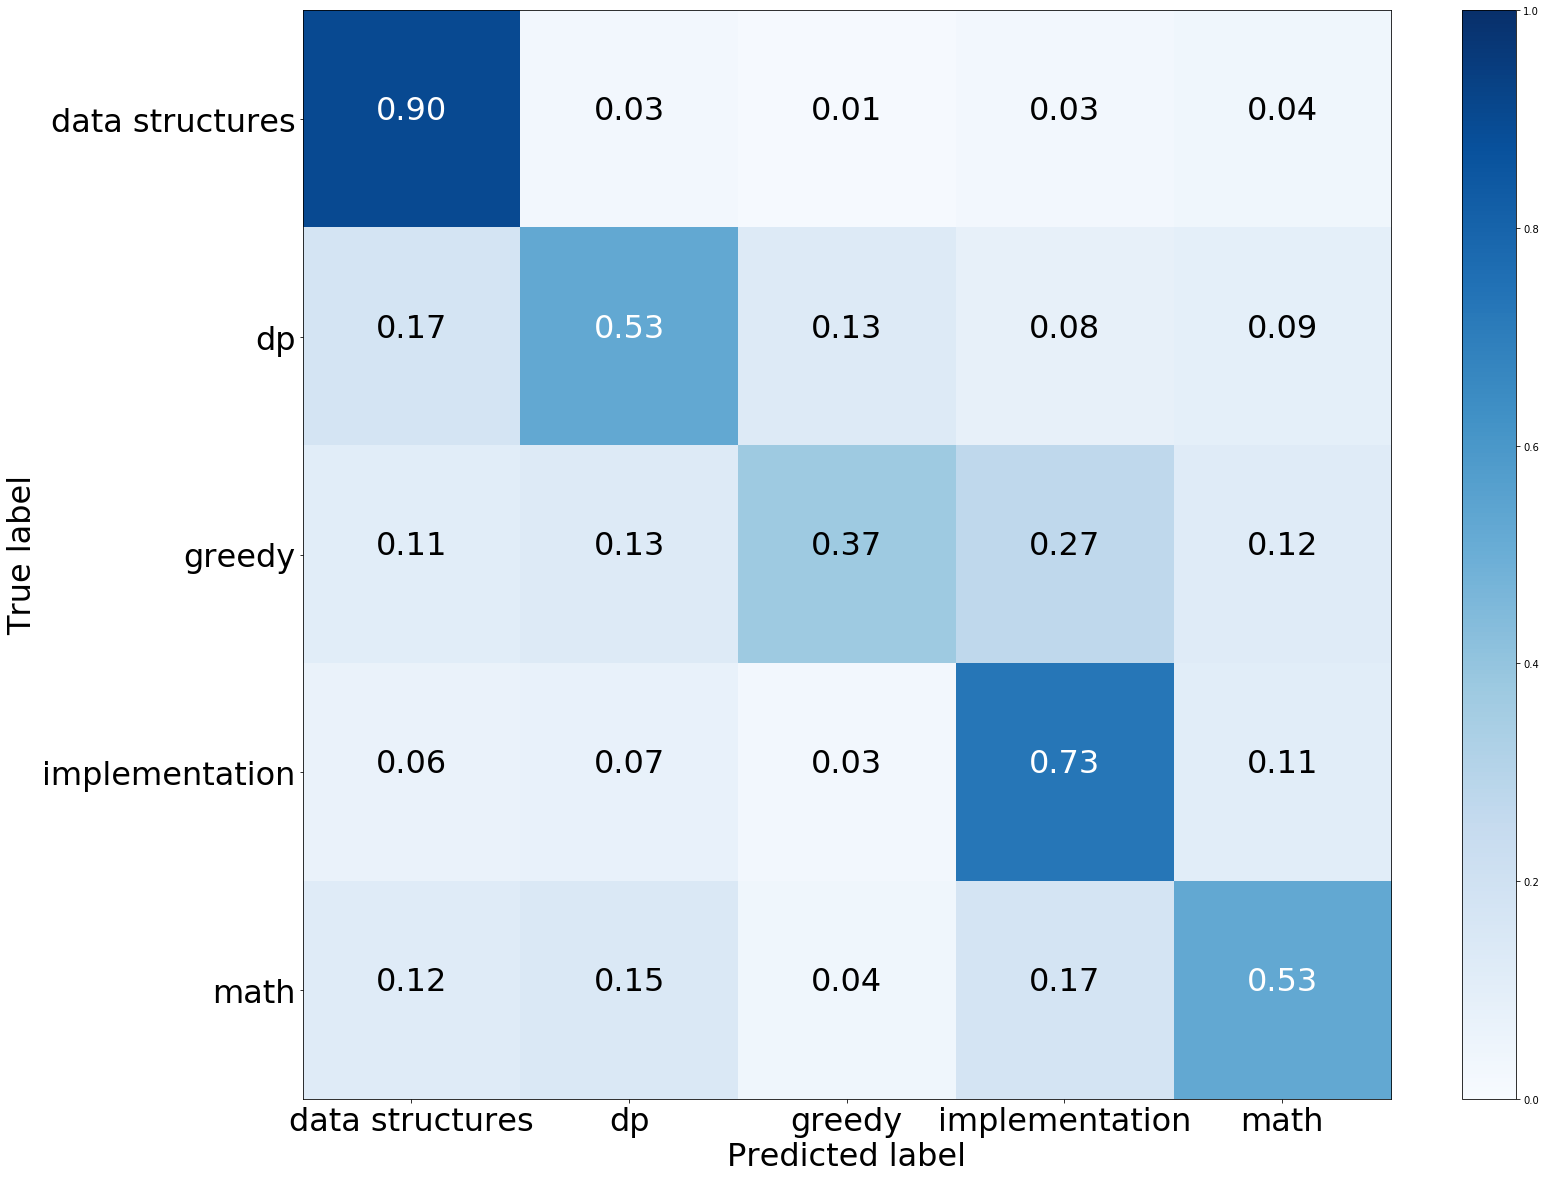

In [17]:
labels = ['data structures', 'dp', 'greedy', 'implementation', 'math']

print(classification_report(targs_txt, preds_txt, labels=labels))
print(accuracy_score(targs_txt, preds_txt))
print(f1_score(targs_txt, preds_txt, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt, labels)

## Classification Analysis

In [18]:
# pickle.dump(X_test_txt, open('data/X_test_5s.pkl', 'wb'))
X_test_txt = pickle.load(open('data/X_test_5s.pkl', 'rb'))

In [37]:
def show_k_examples(label1, label2=None, k=1):
    "Shows k examples for given labels."
    if label2 is None:
        label2 = label1
    examples = []
    for i, (t, p) in enumerate(zip(targs_txt, preds_txt)):
        if t == label1 and p != label2:
            examples.append(X_test_txt[i])
    return random.sample(examples, k)

In [38]:
fpath = 'data/error-analysis/'

ds_correct = show_k_examples('data structures', k=10)
with open(fpath + 'ds_incorrect.txt', 'w') as f:
    for prob in ds_correct:
        f.write(prob)
        f.write('\n\n----------\n\n')

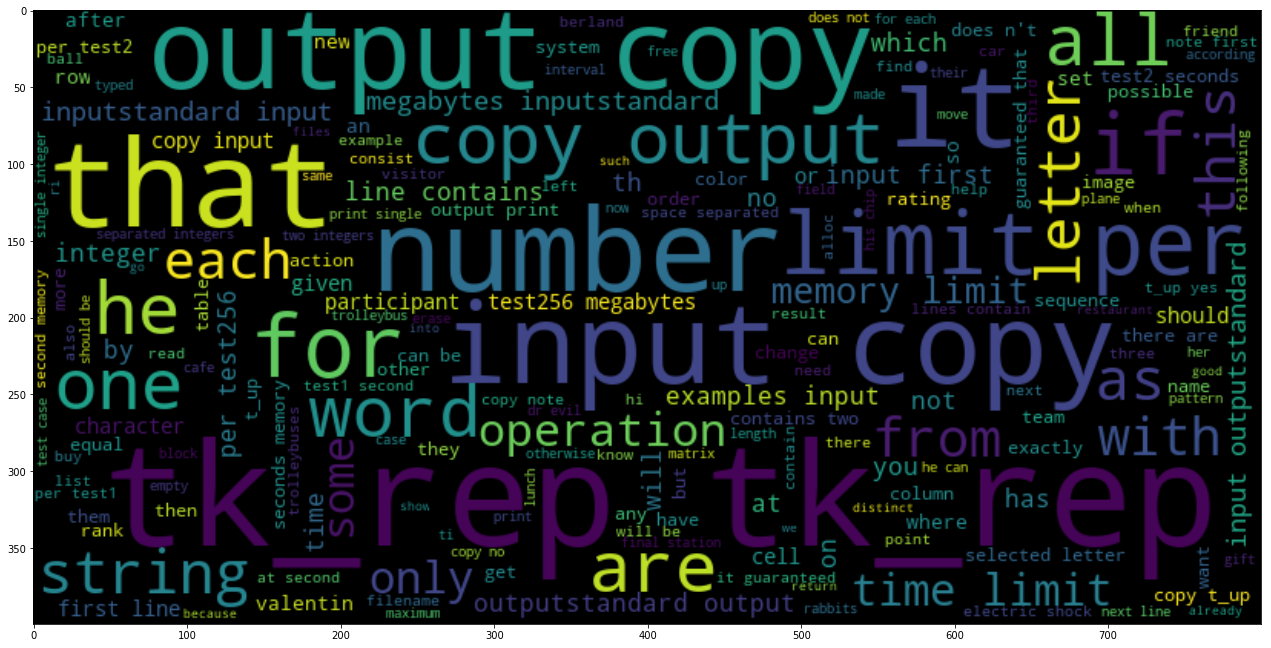

In [87]:
from wordcloud import WordCloud

imp_eg = ' '.join(show_k_examples('implementation', k=30))
fig = plt.gcf()
fig.set_size_inches(22, 16)
i_wc = WordCloud(stopwords=['_unk_', 'the', 'and', 'of', 'in', 'to', 'is'], width=800, height=400).generate(imp_eg)

plt.imshow(m_wc, interpolation='bilinear')

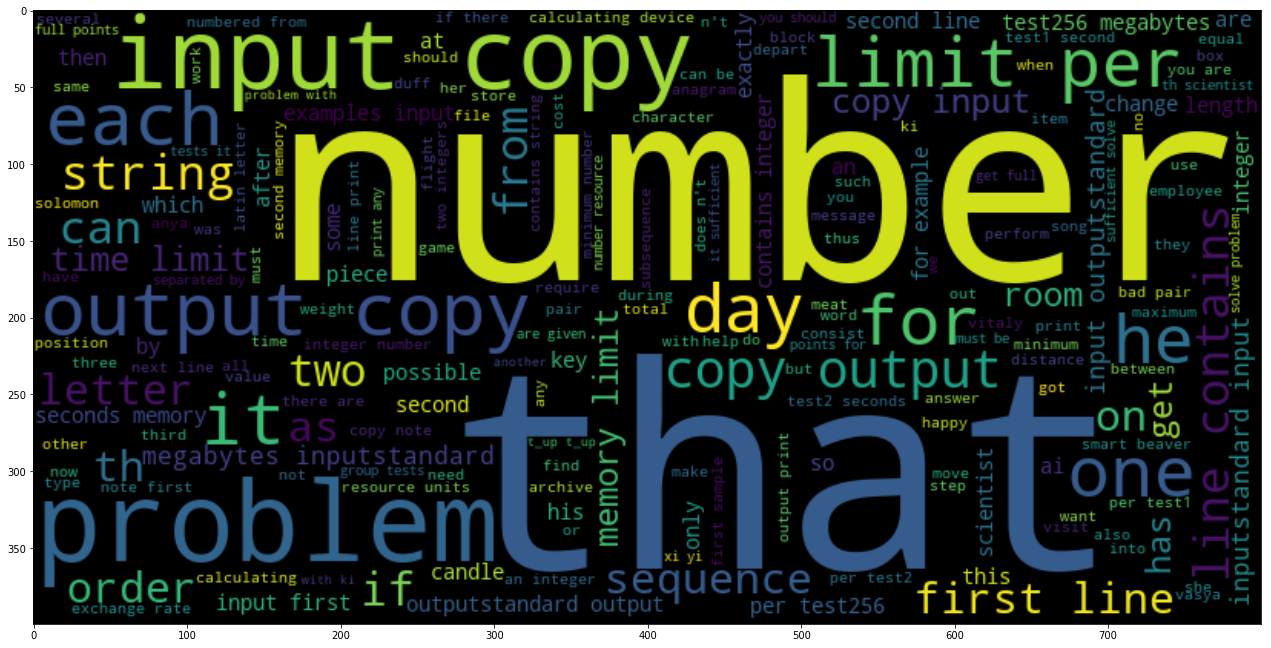

In [89]:
greedy_eg = ' '.join(show_k_examples('greedy', k=30))
g_wc = WordCloud(stopwords=['_unk_', 'the', 'and', 'of', 'in', 'to', 'is'], width=800, height=400).generate(greedy_eg)

fig = plt.gcf()
fig.set_size_inches(22, 16)
plt.imshow(g_wc, interpolation='bilinear')

### 10-class

In [9]:
trunner = TextRunner([None], top10s[0], top10sa[1], 'top10s')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

Checkpoint reached: raw data cleaned.
multiclass classification.


In [36]:
runs = 5
out_dim = 10

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i+42)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textcnn = MWrapper(CNN_Text(in_dim, out_dim),
                           f'{i}_cnntext10s_{j}')
        textcnn.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleDataset(X_train, y_train),
                                 batch_size=32, num_workers=2,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleDataset(X_test, y_test),
                               batch_size=32, num_workers=2,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textcnn.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textcnn.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 10, best_save_name='best')
        
        dl_test = fd.DataLoader(SimpleDataset(X_test, y_test),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        preds_txt += multi_to_text_out(preds, trunner.alldata.ovectorizer)
        targs_txt += multi_to_text_out(targs, trunner.alldata.ovectorizer)
        print(accuracy_score(targs_txt, preds_txt))

Note: Model directory for 0_cnntext10s_0 exists.


epoch      trn_loss   val_loss   accuracy                   
    0      0.082919   0.07986    0.353448  
    1      0.076591   0.07281    0.474138                   
    2      0.067944   0.067542   0.5                        
    3      0.058923   0.067928   0.508621                   
    4      0.049288   0.068369   0.5                        
    5      0.038849   0.067892   0.508621                   
    6      0.028595   0.069697   0.5                        
    7      0.0198     0.071979   0.491379                   
    8      0.013183   0.073603   0.482759                   
    9      0.009078   0.074398   0.491379                    
0.5086206896551724


epoch      trn_loss   val_loss   accuracy                   
    0      0.083545   0.081874   0.327586  
    1      0.077359   0.074458   0.37931                    
    2      0.068491   0.068091   0.491379                   
    3      0.058745   0.06798    0.508621                   
    4      0.048464   0.068661   0.482759                   
    5      0.037701   0.068669   0.491379                   
    6      0.027369   0.069441   0.5                        
    7      0.018524   0.071311   0.534483                   
    8      0.011849   0.074264   0.525862                   
    9      0.007865   0.075885   0.482759                    
0.521551724137931


epoch      trn_loss   val_loss   accuracy                   
    0      0.083445   0.077743   0.362069  
    1      0.075823   0.070097   0.431034                   
    2      0.067216   0.067902   0.482759                   
    3      0.058521   0.066581   0.517241                   
    4      0.048895   0.065992   0.534483                   
    5      0.038416   0.065493   0.551724                   
    6      0.028194   0.066094   0.551724                   
    7      0.019461   0.068326   0.568966                   
    8      0.012973   0.07237    0.534483                   
    9      0.009345   0.084496   0.413793                    
0.5373563218390804


epoch      trn_loss   val_loss   accuracy                   
    0      0.083251   0.078628   0.353448  
    1      0.076727   0.070124   0.482759                   
    2      0.068269   0.065811   0.517241                   
    3      0.059413   0.066113   0.517241                   
    4      0.04972    0.066469   0.508621                   
    5      0.039226   0.066371   0.491379                   
    6      0.028983   0.067653   0.491379                   
    7      0.020099   0.069559   0.474138                   
    8      0.013263   0.071845   0.456897                   
    9      0.008761   0.073941   0.439655                    
0.5323275862068966


epoch      trn_loss   val_loss   accuracy                   
    0      0.082781   0.084453   0.275862  
    1      0.076216   0.075936   0.405172                   
    2      0.067749   0.073533   0.439655                   
    3      0.058922   0.0735     0.456897                   
    4      0.049182   0.073876   0.448276                   
    5      0.038744   0.073157   0.448276                   
    6      0.028657   0.07321    0.448276                   
    7      0.019955   0.07434    0.474138                   
    8      0.013224   0.076059   0.465517                   
    9      0.008736   0.08332    0.439655                    
0.5206896551724138


epoch      trn_loss   val_loss   accuracy                   
    0      0.082986   0.075959   0.396552  
    1      0.076039   0.067424   0.491379                   
    2      0.067513   0.064513   0.543103                   
    3      0.058623   0.063875   0.551724                   
    4      0.048759   0.063251   0.568966                   
    5      0.038106   0.062852   0.577586                   
    6      0.027901   0.063295   0.62069                    
    7      0.019196   0.064214   0.586207                   
    8      0.012543   0.065511   0.568966                   
    9      0.008196   0.068653   0.543103                    
0.5373563218390804


epoch      trn_loss   val_loss   accuracy                   
    0      0.082751   0.084993   0.293103  
    1      0.076814   0.074795   0.396552                   
    2      0.067651   0.068927   0.465517                   
    3      0.058362   0.068901   0.508621                   
    4      0.048247   0.067303   0.525862                   
    5      0.037473   0.066879   0.5                        
    6      0.02716    0.067129   0.508621                   
    7      0.018392   0.067832   0.534483                   
    8      0.011866   0.068167   0.534483                   
    9      0.008228   0.069993   0.551724                    
0.5394088669950738


epoch      trn_loss   val_loss   accuracy                   
    0      0.083033   0.076238   0.396552  
    1      0.075859   0.069337   0.482759                   
    2      0.067351   0.06659    0.474138                   
    3      0.058626   0.066011   0.543103                   
    4      0.048956   0.066678   0.508621                   
    5      0.038502   0.066897   0.543103                   
    6      0.028379   0.067821   0.543103                   
    7      0.01968    0.069465   0.517241                   
    8      0.013014   0.070921   0.508621                   
    9      0.008696   0.070672   0.5                         
0.5398706896551724


epoch      trn_loss   val_loss   accuracy                   
    0      0.083548   0.076769   0.387931  
    1      0.076656   0.068028   0.491379                   
    2      0.068113   0.062678   0.551724                   
    3      0.05932    0.060062   0.577586                   
    4      0.049604   0.059248   0.568966                   
    5      0.039056   0.058481   0.603448                   
    6      0.028753   0.058832   0.594828                   
    7      0.019827   0.059807   0.603448                   
    8      0.013017   0.061385   0.603448                   
    9      0.008662   0.064073   0.568966                    
0.5469348659003831


epoch      trn_loss   val_loss   accuracy                   
    0      0.083052   0.080834   0.347826  
    1      0.076613   0.073743   0.391304                   
    2      0.067503   0.068374   0.469565                   
    3      0.058207   0.067188   0.469565                   
    4      0.048047   0.06659    0.495652                   
    5      0.037107   0.066534   0.504348                   
    6      0.026656   0.06776    0.504348                   
    7      0.017888   0.069255   0.495652                   
    8      0.011438   0.070063   0.478261                   
    9      0.00816    0.071633   0.452174                    
0.542709232096635


epoch      trn_loss   val_loss   accuracy                   
    0      0.083311   0.079762   0.336207  
    1      0.077036   0.06955    0.456897                   
    2      0.06812    0.063177   0.517241                   
    3      0.059007   0.062963   0.525862                   
    4      0.049122   0.063272   0.560345                   
    5      0.038438   0.062349   0.568966                   
    6      0.0281     0.063306   0.551724                   
    7      0.019311   0.065274   0.543103                   
    8      0.012821   0.069518   0.534483                   
    9      0.009417   0.084808   0.465517                    
0.5450980392156862


epoch      trn_loss   val_loss   accuracy                   
    0      0.082826   0.079676   0.353448  
    1      0.076531   0.071612   0.431034                   
    2      0.068066   0.066309   0.5                        
    3      0.059045   0.064521   0.534483                   
    4      0.04888    0.064929   0.534483                   
    5      0.038067   0.065464   0.525862                   
    6      0.027783   0.06617    0.525862                   
    7      0.019106   0.067026   0.534483                   
    8      0.012697   0.067759   0.534483                   
    9      0.010022   0.070405   0.508621                    
0.5442127965492451


epoch      trn_loss   val_loss   accuracy                   
    0      0.083199   0.07773    0.37069   
    1      0.076763   0.067805   0.465517                   
    2      0.068112   0.061979   0.586207                   
    3      0.059035   0.061134   0.586207                   
    4      0.049051   0.061755   0.586207                   
    5      0.038285   0.060752   0.603448                   
    6      0.027939   0.061144   0.586207                   
    7      0.019148   0.061683   0.560345                   
    8      0.012544   0.06306    0.551724                   
    9      0.008334   0.066042   0.543103                    
0.5487723954877239


epoch      trn_loss   val_loss   accuracy                   
    0      0.083158   0.079339   0.362069  
    1      0.076806   0.072458   0.413793                   
    2      0.067901   0.067822   0.491379                   
    3      0.059368   0.066821   0.525862                   
    4      0.050168   0.067025   0.534483                   
    5      0.040149   0.068327   0.517241                   
    6      0.030136   0.0691     0.534483                   
    7      0.021252   0.070388   0.508621                   
    8      0.014234   0.071665   0.508621                   
    9      0.009389   0.071973   0.5                         
0.547751078250154


epoch      trn_loss   val_loss   accuracy                   
    0      0.083108   0.078592   0.353448  
    1      0.076242   0.069048   0.517241                   
    2      0.06688    0.064964   0.517241                   
    3      0.057353   0.063405   0.534483                   
    4      0.046853   0.061398   0.560345                   
    5      0.035916   0.061431   0.577586                   
    6      0.025709   0.06216    0.586207                   
    7      0.017241   0.064076   0.577586                   
    8      0.011118   0.066411   0.603448                   
    9      0.009086   0.07356    0.508621                    
0.5514663599769982


epoch      trn_loss   val_loss   accuracy                   
    0      0.083879   0.074657   0.431034  
    1      0.077375   0.068108   0.517241                   
    2      0.068163   0.065477   0.517241                   
    3      0.058829   0.065481   0.517241                   
    4      0.048815   0.065854   0.491379                   
    5      0.038168   0.066267   0.482759                   
    6      0.027869   0.067778   0.465517                   
    7      0.019042   0.069892   0.465517                   
    8      0.012379   0.072399   0.491379                   
    9      0.008187   0.075781   0.465517                    
0.5493261455525607


epoch      trn_loss   val_loss   accuracy                   
    0      0.083217   0.07903    0.344828  
    1      0.076416   0.071432   0.422414                   
    2      0.067452   0.068122   0.517241                   
    3      0.058382   0.067574   0.525862                   
    4      0.048464   0.06727    0.517241                   
    5      0.037845   0.066917   0.5                        
    6      0.02768    0.067395   0.491379                   
    7      0.019101   0.068266   0.491379                   
    8      0.012639   0.069146   0.508621                   
    9      0.008491   0.073167   0.456897                    
0.547945205479452


epoch      trn_loss   val_loss   accuracy                   
    0      0.08323    0.083652   0.293103  
    1      0.075968   0.075169   0.37931                    
    2      0.06719    0.070885   0.456897                   
    3      0.058192   0.070725   0.474138                   
    4      0.048455   0.070654   0.474138                   
    5      0.038072   0.070262   0.491379                   
    6      0.028047   0.070908   0.482759                   
    7      0.019428   0.071987   0.465517                   
    8      0.012851   0.073155   0.508621                   
    9      0.009108   0.072908   0.465517                    
0.5457594633445136


epoch      trn_loss   val_loss   accuracy                   
    0      0.082855   0.080206   0.327586  
    1      0.075518   0.072725   0.413793                   
    2      0.066723   0.071272   0.439655                   
    3      0.057716   0.071271   0.474138                   
    4      0.047818   0.071328   0.465517                   
    5      0.037215   0.070675   0.482759                   
    6      0.027108   0.071548   0.508621                   
    7      0.018583   0.07381    0.508621                   
    8      0.012213   0.079322   0.491379                   
    9      0.008623   0.087716   0.405172                    
0.5438039037675897


epoch      trn_loss   val_loss   accuracy                   
    0      0.083457   0.081953   0.321739  
    1      0.07645    0.074776   0.365217                   
    2      0.067928   0.070129   0.426087                   
    3      0.059082   0.069147   0.452174                   
    4      0.049326   0.068852   0.495652                   
    5      0.038732   0.068275   0.495652                   
    6      0.028459   0.068631   0.495652                   
    7      0.019613   0.070098   0.504348                   
    8      0.012904   0.071865   0.504348                   
    9      0.008628   0.073175   0.495652                    
0.5418464193270061


epoch      trn_loss   val_loss   accuracy                   
    0      0.083475   0.076479   0.396552  
    1      0.076877   0.068145   0.5                        
    2      0.068177   0.065616   0.568966                   
    3      0.059248   0.065089   0.568966                   
    4      0.049292   0.06541    0.551724                   
    5      0.038452   0.065281   0.568966                   
    6      0.028013   0.066552   0.543103                   
    7      0.019193   0.069086   0.517241                   
    8      0.012638   0.073993   0.491379                   
    9      0.008773   0.083221   0.474138                    
0.543138866064092


epoch      trn_loss   val_loss   accuracy                   
    0      0.083146   0.083822   0.301724  
    1      0.077223   0.076383   0.362069                   
    2      0.068646   0.069799   0.439655                   
    3      0.059514   0.068805   0.439655                   
    4      0.049748   0.068531   0.448276                   
    5      0.039208   0.068278   0.456897                   
    6      0.028867   0.068704   0.448276                   
    7      0.020017   0.070298   0.482759                   
    8      0.013304   0.072281   0.431034                   
    9      0.009126   0.073951   0.448276                    
0.5403921568627451


epoch      trn_loss   val_loss   accuracy                   
    0      0.083131   0.085072   0.258621  
    1      0.077103   0.07687    0.344828                   
    2      0.068558   0.070383   0.439655                   
    3      0.059544   0.068201   0.431034                   
    4      0.049835   0.067992   0.474138                   
    5      0.039342   0.067203   0.491379                   
    6      0.028989   0.067645   0.482759                   
    7      0.020048   0.068535   0.508621                   
    8      0.013191   0.069489   0.491379                   
    9      0.008794   0.071686   0.448276                    
0.5390097524381096


epoch      trn_loss   val_loss   accuracy                   
    0      0.083553   0.077907   0.387931  
    1      0.077955   0.070217   0.482759                   
    2      0.06939    0.066119   0.517241                   
    3      0.060221   0.067089   0.534483                   
    4      0.050541   0.067525   0.525862                   
    5      0.040046   0.067213   0.534483                   
    6      0.029577   0.067575   0.525862                   
    7      0.020431   0.068696   0.534483                   
    8      0.013391   0.069305   0.525862                   
    9      0.008779   0.069682   0.474138                    
0.5388209920920202


epoch      trn_loss   val_loss   accuracy                   
    0      0.083022   0.081498   0.318966  
    1      0.076527   0.072901   0.431034                   
    2      0.067858   0.068489   0.474138                   
    3      0.059181   0.066774   0.491379                   
    4      0.049649   0.066462   0.525862                   
    5      0.039357   0.066324   0.568966                   
    6      0.029243   0.066134   0.551724                   
    7      0.020464   0.066308   0.551724                   
    8      0.013637   0.067287   0.517241                   
    9      0.009059   0.069981   0.543103                    
0.5400276052449966


epoch      trn_loss   val_loss   accuracy                   
    0      0.082576   0.080722   0.327586  
    1      0.075562   0.072698   0.396552                   
    2      0.066756   0.068911   0.422414                   
    3      0.057852   0.067488   0.517241                   
    4      0.047968   0.066892   0.517241                   
    5      0.037398   0.066363   0.525862                   
    6      0.027361   0.067359   0.534483                   
    7      0.018855   0.07004    0.517241                   
    8      0.012455   0.07446    0.491379                   
    9      0.00891    0.080549   0.431034                    
0.539814200398142


epoch      trn_loss   val_loss   accuracy                   
    0      0.083246   0.077872   0.387931  
    1      0.076231   0.071244   0.439655                   
    2      0.067479   0.06871    0.5                        
    3      0.058515   0.069409   0.491379                   
    4      0.048636   0.069675   0.508621                   
    5      0.037996   0.069272   0.517241                   
    6      0.027829   0.070345   0.5                        
    7      0.019125   0.072291   0.534483                   
    8      0.012573   0.074778   0.508621                   
    9      0.008731   0.07824    0.465517                    
0.5396166134185304


epoch      trn_loss   val_loss   accuracy                   
    0      0.083332   0.078116   0.387931  
    1      0.077044   0.071466   0.465517                   
    2      0.068205   0.066768   0.525862                   
    3      0.05889    0.067072   0.508621                   
    4      0.048552   0.067108   0.517241                   
    5      0.0375     0.066657   0.517241                   
    6      0.027109   0.067527   0.543103                   
    7      0.018416   0.068381   0.568966                   
    8      0.011917   0.068694   0.577586                   
    9      0.007716   0.068887   0.560345                    
0.540973505853358


epoch      trn_loss   val_loss   accuracy                   
    0      0.08332    0.076922   0.37931   
    1      0.076825   0.068528   0.5                        
    2      0.068372   0.06396    0.594828                   
    3      0.059323   0.063445   0.577586                   
    4      0.049138   0.063557   0.586207                   
    5      0.038115   0.064185   0.568966                   
    6      0.02766    0.065831   0.543103                   
    7      0.01888    0.068      0.5                        
    8      0.012363   0.069966   0.517241                   
    9      0.00907    0.070786   0.517241                    
0.5428316478286734


epoch      trn_loss   val_loss   accuracy                   
    0      0.082738   0.079155   0.347826  
    1      0.076197   0.070937   0.46087                    
    2      0.067372   0.066445   0.521739                   
    3      0.058233   0.065581   0.573913                   
    4      0.048273   0.065314   0.591304                   
    5      0.037476   0.064554   0.6                        
    6      0.027012   0.065512   0.582609                   
    7      0.018097   0.067396   0.582609                   
    8      0.011494   0.069514   0.53913                    
    9      0.007838   0.072418   0.547826                    
0.544722461892436


epoch      trn_loss   val_loss   accuracy                   
    0      0.083313   0.076257   0.396552  
    1      0.077408   0.06825    0.482759                   
    2      0.068691   0.064944   0.560345                   
    3      0.059814   0.064465   0.534483                   
    4      0.050285   0.064656   0.543103                   
    5      0.03984    0.064204   0.560345                   
    6      0.029417   0.064272   0.551724                   
    7      0.020273   0.065976   0.525862                   
    8      0.013182   0.066971   0.525862                   
    9      0.008567   0.067978   0.517241                    
0.5452268299471194


epoch      trn_loss   val_loss   accuracy                   
    0      0.08374    0.077706   0.37931   
    1      0.076952   0.068845   0.491379                   
    2      0.067745   0.063495   0.534483                   
    3      0.058231   0.061993   0.586207                   
    4      0.047622   0.06231    0.586207                   
    5      0.036333   0.062498   0.586207                   
    6      0.025902   0.063768   0.586207                   
    7      0.017338   0.06522    0.594828                   
    8      0.011128   0.06778    0.577586                   
    9      0.007491   0.072239   0.534483                    
0.5467781073065516


epoch      trn_loss   val_loss   accuracy                   
    0      0.083584   0.082398   0.327586  
    1      0.076962   0.075116   0.413793                   
    2      0.067861   0.070725   0.448276                   
    3      0.058825   0.069906   0.474138                   
    4      0.04911    0.070148   0.5                        
    5      0.03884    0.070327   0.482759                   
    6      0.028835   0.071245   0.5                        
    7      0.020346   0.07345    0.5                        
    8      0.014332   0.078311   0.456897                   
    9      0.012873   0.076073   0.465517                   
0.545359477124183


epoch      trn_loss   val_loss   accuracy                   
    0      0.083291   0.081948   0.310345  
    1      0.0768     0.073031   0.413793                   
    2      0.068175   0.068163   0.491379                   
    3      0.059513   0.067896   0.517241                   
    4      0.050033   0.067964   0.508621                   
    5      0.039606   0.068329   0.482759                   
    6      0.029245   0.068433   0.474138                   
    7      0.020294   0.069337   0.465517                   
    8      0.013443   0.070736   0.448276                   
    9      0.009064   0.071475   0.465517                    
0.5445318447094646


epoch      trn_loss   val_loss   accuracy                   
    0      0.083044   0.077061   0.37069   
    1      0.076246   0.06683    0.508621                   
    2      0.067601   0.061547   0.551724                   
    3      0.058616   0.061135   0.568966                   
    4      0.048656   0.061754   0.612069                   
    5      0.037816   0.061315   0.612069                   
    6      0.027534   0.061983   0.612069                   
    7      0.018843   0.063354   0.62931                    
    8      0.012351   0.064993   0.62931                    
    9      0.008405   0.068762   0.612069                    
0.5469558787281242


epoch      trn_loss   val_loss   accuracy                   
    0      0.083171   0.080105   0.336207  
    1      0.07633    0.0712     0.413793                   
    2      0.06745    0.067042   0.517241                   
    3      0.058321   0.067328   0.5                        
    4      0.048322   0.067795   0.5                        
    5      0.037683   0.068094   0.482759                   
    6      0.027718   0.069826   0.491379                   
    7      0.019378   0.073395   0.448276                   
    8      0.013303   0.079764   0.431034                   
    9      0.010672   0.082042   0.456897                   
0.5461298825784807


epoch      trn_loss   val_loss   accuracy                   
    0      0.082632   0.078678   0.344828  
    1      0.075663   0.072036   0.422414                   
    2      0.067018   0.070223   0.413793                   
    3      0.058235   0.069295   0.439655                   
    4      0.048517   0.069304   0.465517                   
    5      0.038139   0.069089   0.482759                   
    6      0.02822    0.069769   0.508621                   
    7      0.019788   0.073006   0.491379                   
    8      0.013545   0.081445   0.37069                    
    9      0.011777   0.095757   0.336207                   
0.5451154115178364


epoch      trn_loss   val_loss   accuracy                   
    0      0.083455   0.079085   0.37069   
    1      0.076951   0.07209    0.491379                   
    2      0.067936   0.06883    0.577586                   
    3      0.058844   0.068102   0.517241                   
    4      0.049084   0.068065   0.525862                   
    5      0.038705   0.067876   0.551724                   
    6      0.028628   0.0688     0.543103                   
    7      0.019894   0.070071   0.525862                   
    8      0.01309    0.070532   0.517241                   
    9      0.008541   0.070471   0.534483                    
0.5459704880817253


epoch      trn_loss   val_loss   accuracy                   
    0      0.082851   0.07743    0.37931   
    1      0.07632    0.071368   0.413793                   
    2      0.06739    0.06863    0.474138                   
    3      0.058415   0.067493   0.517241                   
    4      0.048435   0.0672     0.534483                   
    5      0.037611   0.066675   0.568966                   
    6      0.027192   0.067859   0.568966                   
    7      0.018402   0.069649   0.551724                   
    8      0.011877   0.072051   0.551724                   
    9      0.008129   0.075082   0.543103                    
0.5465604954656049


epoch      trn_loss   val_loss   accuracy                   
    0      0.083357   0.085797   0.278261  
    1      0.07661    0.07643    0.356522                   
    2      0.067487   0.070731   0.452174                   
    3      0.058548   0.069633   0.443478                   
    4      0.048726   0.069567   0.452174                   
    5      0.038052   0.069532   0.46087                    
    6      0.027702   0.070011   0.469565                   
    7      0.018976   0.070942   0.452174                   
    8      0.012482   0.072423   0.469565                   
    9      0.008555   0.072073   0.513043                    
0.5457290767903364


epoch      trn_loss   val_loss   accuracy                   
    0      0.083868   0.07746    0.387931  
    1      0.077109   0.070595   0.482759                   
    2      0.068602   0.066348   0.5                        
    3      0.059773   0.06403    0.543103                   
    4      0.050137   0.063556   0.560345                   
    5      0.039739   0.062814   0.568966                   
    6      0.029593   0.062537   0.603448                   
    7      0.020829   0.062487   0.603448                   
    8      0.014307   0.062538   0.594828                   
    9      0.01098    0.066011   0.560345                   
0.5471380471380471


epoch      trn_loss   val_loss   accuracy                   
    0      0.083327   0.076501   0.405172  
    1      0.077208   0.070214   0.456897                   
    2      0.068712   0.067037   0.5                        
    3      0.059366   0.06746    0.534483                   
    4      0.048882   0.067251   0.525862                   
    5      0.0378     0.067434   0.551724                   
    6      0.027488   0.068559   0.551724                   
    7      0.018844   0.069542   0.551724                   
    8      0.012349   0.070883   0.534483                   
    9      0.008247   0.073407   0.5                         
0.5472473294987674


epoch      trn_loss   val_loss   accuracy                   
    0      0.082664   0.081759   0.310345  
    1      0.076042   0.075249   0.387931                   
    2      0.067663   0.072077   0.465517                   
    3      0.0587     0.06998    0.465517                   
    4      0.048594   0.068936   0.482759                   
    5      0.037643   0.067917   0.491379                   
    6      0.027245   0.068232   0.517241                   
    7      0.018551   0.068905   0.517241                   
    8      0.012176   0.069718   0.5                        
    9      0.008559   0.074042   0.482759                    
0.5465489566613162


epoch      trn_loss   val_loss   accuracy                   
    0      0.083      0.081666   0.284483  
    1      0.07649    0.072512   0.439655                   
    2      0.068199   0.066625   0.525862                   
    3      0.059538   0.064676   0.525862                   
    4      0.050094   0.06441    0.551724                   
    5      0.039858   0.064079   0.594828                   
    6      0.029756   0.064248   0.586207                   
    7      0.020989   0.066091   0.586207                   
    8      0.01442    0.06964    0.534483                   
    9      0.010938   0.069095   0.560345                   
0.5476470588235294


epoch      trn_loss   val_loss   accuracy                   
    0      0.08271    0.079147   0.344828  
    1      0.075946   0.068439   0.517241                   
    2      0.067091   0.064683   0.560345                   
    3      0.057768   0.06503    0.525862                   
    4      0.047463   0.064753   0.560345                   
    5      0.036535   0.064487   0.551724                   
    6      0.026356   0.065206   0.560345                   
    7      0.017896   0.06674    0.577586                   
    8      0.01183    0.067857   0.568966                   
    9      0.009749   0.08286    0.474138                    
0.5483128834355828


epoch      trn_loss   val_loss   accuracy                   
    0      0.08347    0.078163   0.362069  
    1      0.076817   0.069285   0.431034                   
    2      0.068023   0.063891   0.577586                   
    3      0.059109   0.062008   0.603448                   
    4      0.049509   0.061019   0.637931                   
    5      0.039242   0.060902   0.646552                   
    6      0.02917    0.061426   0.62931                    
    7      0.02039    0.062332   0.62931                    
    8      0.013618   0.063097   0.62069                    
    9      0.009197   0.063847   0.594828                    
0.550450112528132


epoch      trn_loss   val_loss   accuracy                   
    0      0.082851   0.077782   0.413793  
    1      0.0767     0.069207   0.508621                   
    2      0.068015   0.066472   0.525862                   
    3      0.058795   0.067743   0.543103                   
    4      0.048718   0.069232   0.543103                   
    5      0.037962   0.069529   0.508621                   
    6      0.027684   0.071559   0.491379                   
    7      0.019042   0.074832   0.508621                   
    8      0.012639   0.079516   0.474138                   
    9      0.008875   0.086359   0.431034                    
0.5502936857562408


epoch      trn_loss   val_loss   accuracy                   
    0      0.083806   0.079086   0.362069  
    1      0.076968   0.07101    0.431034                   
    2      0.068063   0.06616    0.508621                   
    3      0.059301   0.064844   0.5                        
    4      0.049829   0.065403   0.534483                   
    5      0.039479   0.065171   0.517241                   
    6      0.029285   0.065934   0.525862                   
    7      0.020415   0.067173   0.508621                   
    8      0.013533   0.068664   0.517241                   
    9      0.008824   0.070123   0.517241                    
0.5499640546369519


epoch      trn_loss   val_loss   accuracy                   
    0      0.08293    0.083792   0.284483  
    1      0.076161   0.075843   0.37069                    
    2      0.067887   0.071811   0.422414                   
    3      0.05908    0.071433   0.431034                   
    4      0.04918    0.071737   0.465517                   
    5      0.038593   0.071663   0.474138                   
    6      0.028457   0.07238    0.439655                   
    7      0.019778   0.073405   0.465517                   
    8      0.013155   0.075126   0.448276                   
    9      0.008947   0.081111   0.439655                    
0.5484154929577465


epoch      trn_loss   val_loss   accuracy                   
    0      0.083294   0.081174   0.33913   
    1      0.076742   0.073202   0.443478                   
    2      0.068162   0.071323   0.46087                    
    3      0.059108   0.07108    0.46087                    
    4      0.048979   0.07097    0.46087                    
    5      0.038042   0.070621   0.46087                    
    6      0.027601   0.072396   0.486957                   
    7      0.018927   0.076435   0.530435                   
    8      0.01284    0.085699   0.46087                    
    9      0.011894   0.083724   0.408696                   
0.5480586712683347


In [37]:
# pickle.dump([preds_txt, targs_txt], open('data/results/cnn_10s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/cnn_10s.pkl', 'rb'))

                         precision    recall  f1-score   support

            brute force       0.00      0.00      0.00       325
constructive algorithms       0.34      0.25      0.29       320
        data structures       0.63      0.68      0.65       550
                     dp       0.54      0.48      0.51       720
        dfs and similar       0.52      0.16      0.24       180
               geometry       0.56      0.74      0.64       245
                 greedy       0.40      0.27      0.32       605
         implementation       0.64      0.83      0.73      2025
                   math       0.35      0.42      0.38       660
                strings       0.44      0.21      0.29       165

            avg / total       0.50      0.55      0.51      5795

0.5480586712683347
0.5147683922912554
Normalized confusion matrix
[[0.      0.04    0.04615 0.10154 0.00308 0.01231 0.09231 0.48923 0.20923 0.00615]
 [0.00625 0.24688 0.05312 0.04063 0.03125 0.04688 0.1     0.26562 0.

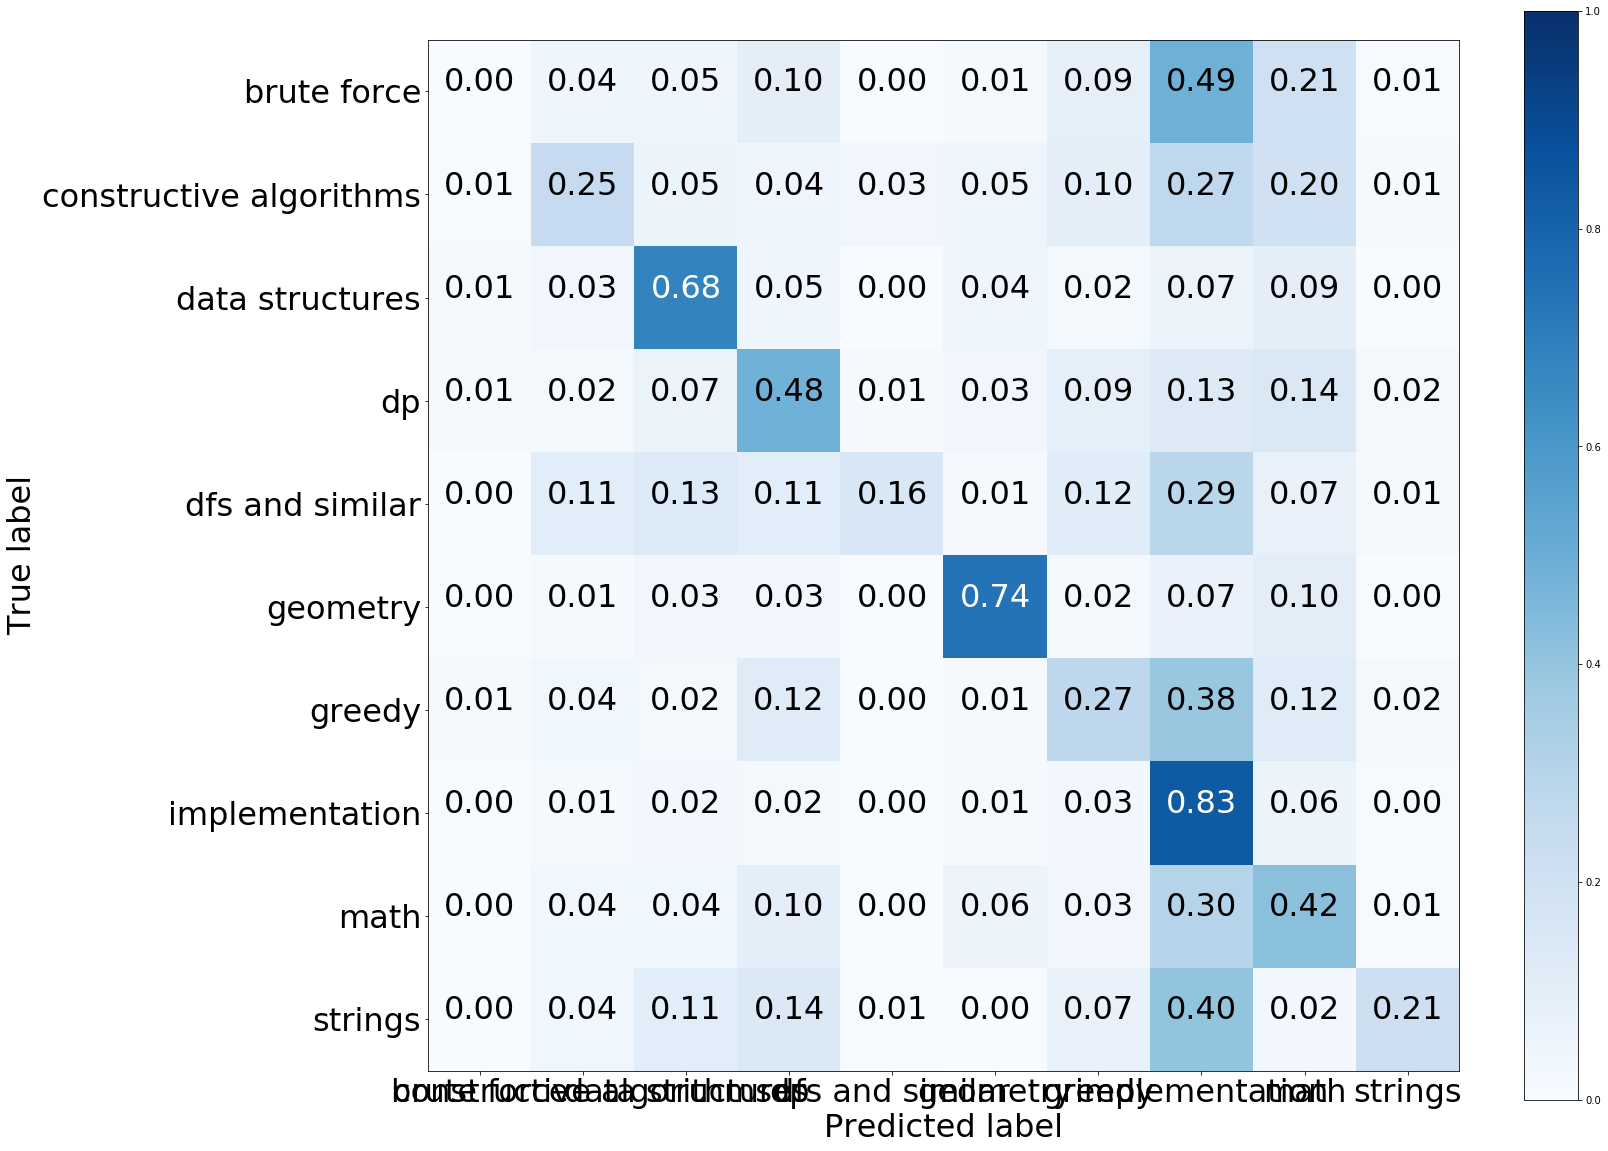

In [38]:
labels = ['brute force', 'constructive algorithms', 'data structures',
          'dp', 'dfs and similar', 'geometry', 'greedy',
          'implementation', 'math', 'strings']

print(classification_report(targs_txt, preds_txt, labels=labels))
print(accuracy_score(targs_txt, preds_txt))
print(f1_score(targs_txt, preds_txt, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt, labels)